# Nudge LLM Trajectories via Emotional Axes

_See `notebooks/llm emotional control.pdf` for less abstract treatment._

In this notebook we will demonstrate control over probabilities assigned to 
trajectories $t_i^+, t_i^-$ for $i\in[N]$ from $t_i^+ \sim P_{LM}(t_i^+ | x_0^+)$ 
and $t_i^- \sim P_{LM}(t_i^- | x_0^-)$ i.i.d. 

**Experiment 1**: cache `key_value_plus`, `key_value_minus` from
*`model(x_0_plus)`, `model(x_0_minus)` 
k

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# gpt-2 model 
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [2]:
# Load the gpt-2 model 
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to('cuda')

# model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name).to('cuda')

## 1: Compute `past_kv_plus`, `past_kv_minus`

In [3]:
# define dataset 
x_0_plus = "Bob was extremely happy, therefore Bob"
x_0_minus = "Bob was extremely sad, therefore Bob"

# tokenize as pytorch tensors 
x_0_plus_ids = tokenizer.encode(x_0_plus, return_tensors='pt').to('cuda')
x_0_minus_ids = tokenizer.encode(x_0_minus, return_tensors='pt').to('cuda')
print("x_0_plus_ids: ", x_0_plus_ids)
print("x_0_minus_ids: ", x_0_minus_ids)

# ensure tokenizer can decode
print("x_0_plus: ", tokenizer.decode(x_0_plus_ids[0]))
print("x_0_minus: ", tokenizer.decode(x_0_minus_ids[0]))

# retrieve past_kv_plus and past_kv_minus 
with torch.no_grad():
    outputs = model(x_0_plus_ids, past_key_values=None)
    past_kv_plus = outputs.past_key_values
    outputs = model(x_0_minus_ids, past_key_values=None)
    past_kv_minus = outputs.past_key_values

x_0_plus_ids:  tensor([[18861,   373,  4457,  3772,    11,  4361,  5811]], device='cuda:0')
x_0_minus_ids:  tensor([[18861,   373,  4457,  6507,    11,  4361,  5811]], device='cuda:0')
x_0_plus:  Bob was extremely happy, therefore Bob
x_0_minus:  Bob was extremely sad, therefore Bob


In [4]:
# let's go through one token at a time: 
for i in range(x_0_plus_ids.shape[1]): 
    print(f"Decoded {x_0_plus_ids[0, i]}: `{tokenizer.decode(x_0_plus_ids[0, i])}`")

Decoded 18861: `Bob`
Decoded 373: ` was`
Decoded 4457: ` extremely`
Decoded 3772: ` happy`
Decoded 11: `,`
Decoded 4361: ` therefore`
Decoded 5811: ` Bob`


 - `past_kv_plus`, `past_kv_minus` are tuples of length `num_layer=12`. 
 - `past_kv[l]` is a tuple of length 2 (key, values) for layer `l`
 - `past_kv[l][0]` are the keys for layer `l`, shape `[b, num_heads, ]


In [5]:
print("0th layer, keys shape: ", past_kv_plus[0][0].shape) 
print(f"\tshape [batch, num_heads, seq_len, head_dim]")
print("0th layer, values shape: ", past_kv_plus[0][1].shape)
print(f"\tshape [batch, num_heads, seq_len, head_dim]")


0th layer, keys shape:  torch.Size([1, 12, 7, 64])
	shape [batch, num_heads, seq_len, head_dim]
0th layer, values shape:  torch.Size([1, 12, 7, 64])
	shape [batch, num_heads, seq_len, head_dim]


In [6]:
# print("Number of heads in gpt2 attention: ", model.transformer.h[0].attn.num_heads)
# print("Head dim in gpt2 attention: ", model.transformer.h[0].attn.head_dim)

## 2: Sample trajectories $t_i^\pm \sim P_{LLM}(t_i^\pm | \text{past kv}^\pm)$

In [7]:
# Set the number of trajectories to sample
num_trajectories = 200
max_length = 10

In [8]:
# Function to sample a trajectory given the model, tokenizer, prompt, and past_kv
def sample_trajectory(model, tokenizer, past_kv, prompt_ids, max_length):
    """ Samples t ~ P_{LLM}(t | past_kv + prompt_ids)
    """
    # print("Prompt_ids shape: ", prompt_ids.shape)
    # print("Past kv shape value 0: ", past_kv[0][0].shape)

    num_past_toks = past_kv[0][0].shape[2]
    attention_mask = torch.ones([1, prompt_ids.shape[1] + num_past_toks]).to(model.device)
    # print("Attention mask shape: ", attention_mask.shape)

    with torch.no_grad():
        generated_ids = model.generate(
            prompt_ids,
            max_length=max_length,
            no_repeat_ngram_size=3,
            do_sample=True,
            top_p=0.95,
            top_k=100,
            temperature=0.8,
            attention_mask=attention_mask,
            bad_words_ids=None,
            past_key_values=past_kv
        ).to('cuda')
    
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    return generated_text, generated_ids

In [9]:
# test the sample trajectory function 
prompt = " did"
prompt_ids = tokenizer.encode(prompt, return_tensors='pt').to('cuda')

# t_plus_str is a string, t_plus_ids is a tensor of shape [1, traj_len], including the extra `prompt`
t_plus_str, t_plus_ids = sample_trajectory(model, tokenizer, past_kv_plus, prompt_ids, max_length)
print("[Trajectory plus: ]", t_plus_str)
print("\nNumber of tokens in trajectory: ", t_plus_ids.shape)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Trajectory plus: ]  did not have to worry about being sick again.

Number of tokens in trajectory:  torch.Size([1, 10])


In [10]:
t_min_str, t_min_ids = sample_trajectory(model, tokenizer, past_kv_minus, prompt_ids, max_length)
print("[Trajectory minus: ]", t_min_str)

print("\nNumber of tokens in trajectory: ", t_min_ids.shape)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Trajectory minus: ]  did not listen to the news and did not have

Number of tokens in trajectory:  torch.Size([1, 10])


In [11]:
# Sample trajectories for x_0_plus
prompt = " did"
prompt_ids = tokenizer.encode(prompt, return_tensors='pt').to('cuda')

trajectories_plus = []
for _ in tqdm(range(num_trajectories), desc="Sampling x_0_plus trajectories"):
    t_plus_str, t_plus_ids = sample_trajectory(model, tokenizer, past_kv_plus, prompt_ids, max_length)
    trajectories_plus.append({'str': t_plus_str, 'ids': t_plus_ids})

# Sample trajectories for x_0_minus
trajectories_minus = []
for _ in tqdm(range(num_trajectories), desc="Sampling x_0_minus trajectories"):
    t_minus_str, t_minus_ids = sample_trajectory(model, tokenizer, past_kv_minus, prompt_ids, max_length)
    trajectories_minus.append({'str': t_minus_str, 'ids': t_minus_ids})


Sampling x_0_plus trajectories:   0%|          | 0/200 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Sampling x_0_plus trajectories:   1%|          | 2/200 [00:00<00:15, 12.56it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Sampling x_0_plus trajectories:   2%|▏         | 4/200 [00:00<00:15, 12.66it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Sampling x_0_plus trajectories:   3%|▎         | 6/200 [00:00<00:15, 12.68it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Sampling x_0_plus trajectories:   4%|▍         | 8/200 [00:00<00:15, 12.66it/s]Setting `pad_token_id` to `eos_token_

In [12]:
t_plus_lens = [t['ids'].shape[1] for t in trajectories_plus]
t_minus_lens = [t['ids'].shape[1] for t in trajectories_minus]

print(t_plus_lens)
print(t_minus_lens)

# keep only those trajectories that are = max_length
trajectories_plus = [t for t in trajectories_plus if t['ids'].shape[1] == max_length]
trajectories_minus = [t for t in trajectories_minus if t['ids'].shape[1] == max_length]

# ensure both are of the same length 
if len(trajectories_plus) > len(trajectories_minus):
    trajectories_plus = trajectories_plus[:len(trajectories_minus)]
else:
    trajectories_minus = trajectories_minus[:len(trajectories_plus)]

print("\nt_plus length: ", len(trajectories_plus))
print("t_minus length: ", len(trajectories_minus))

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

In [13]:
# trajectories_plus[0]['str']

In [14]:
# past_kv_plus[0][0].shape

In [15]:
# trajectories_plus[0]['ids'].shape

## 2.5: Computing Trajectory $t_i^\pm$ Probabilities given $x_0^\pm$

In [16]:
# now let's compute the probability of each trajectory given each prompt 
def get_traj_prob(traj_ids, past_kv, model): 
    """ Computes the probability of a trajectory given the past_kv. 
    """
    num_kv_toks = past_kv[0][0].shape[2]
    num_traj_toks = traj_ids.shape[1]

    labels = traj_ids 
    attention_mask = torch.ones([1, num_kv_toks + num_traj_toks]).to(model.device)

    with torch.no_grad():
        outputs = model(traj_ids, past_key_values=past_kv, labels=labels, attention_mask=attention_mask)
        loss = outputs.loss
        log_prob = -loss
    
    return log_prob.item()

In [17]:
# test get_traj_prob function 
traj_prob = get_traj_prob(trajectories_minus[0]['ids'], past_kv_plus, model)
print("Trajectory log probability: ", traj_prob)

Trajectory log probability:  -2.2974042892456055


No we can compute the log probability of each trajectory given its corresponding 
past_kv +/-

In [18]:
# Compute log probabilities for x_0_plus trajectories
for trajectory in tqdm(trajectories_plus, desc="Computing log probs for x_0_plus trajectories"):
    log_prob = get_traj_prob(trajectory['ids'], past_kv_plus, model)
    trajectory['log_prob'] = log_prob

# Compute log probabilities for x_0_minus trajectories
for trajectory in tqdm(trajectories_minus, desc="Computing log probs for x_0_minus trajectories"):
    log_prob = get_traj_prob(trajectory['ids'], past_kv_minus, model)
    trajectory['log_prob'] = log_prob

# add a field (log_prob_other) for log P(t_plus | x_0_minus) and log P(t_minus | x_0_plus) 
for trajectory in tqdm(trajectories_plus, desc="Computing log probs for x_0_plus trajectories_minus"):
    log_prob_other = get_traj_prob(trajectory['ids'], past_kv_minus, model)
    trajectory['log_prob_given_other'] = log_prob_other

for trajectory in tqdm(trajectories_minus, desc="Computing log probs for x_0_minus trajectories_plus"):
    log_prob_other = get_traj_prob(trajectory['ids'], past_kv_plus, model)
    trajectory['log_prob_given_other'] = log_prob_other

Computing log probs for x_0_minus trajectories: 100%|██████████| 200/200 [00:01<00:00, 124.56it/s]
Computing log probs for x_0_plus trajectories_minus: 100%|██████████| 200/200 [00:01<00:00, 125.29it/s]
Computing log probs for x_0_minus trajectories_plus: 100%|██████████| 200/200 [00:01<00:00, 125.45it/s]


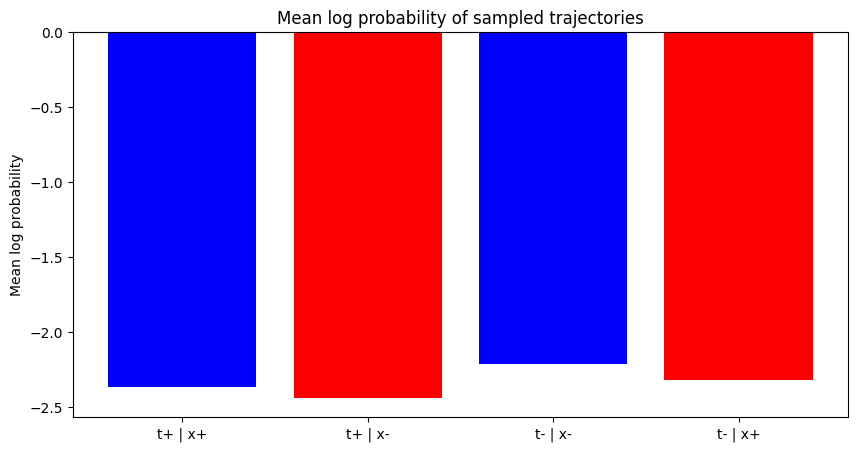

In [19]:
mean_log_prob_plus = np.mean([t['log_prob'] for t in trajectories_plus])
mean_log_prob_minus = np.mean([t['log_prob'] for t in trajectories_minus])

mean_log_prob_plus_given_other = np.mean([t['log_prob_given_other'] for t in trajectories_plus])
mean_log_prob_minus_given_other = np.mean([t['log_prob_given_other'] for t in trajectories_minus])

# bar chart 
plt.figure(figsize=(10, 5))
plt.bar(['t+ | x+', 't+ | x-', 't- | x-', 't- | x+'], [mean_log_prob_plus, mean_log_prob_plus_given_other, mean_log_prob_minus, mean_log_prob_minus_given_other], color=['blue', 'red', 'blue', 'red'])
# colors 
# adjust y axis range
# plt.ylim([-2.5, -2.0])
plt.ylabel('Mean log probability')
plt.title('Mean log probability of sampled trajectories')
plt.show()


## 3: Generating $\text{past kv}^\lambda$

In [20]:
# generate a bunch of lambda values between 0 and 1 (np linspace or something)
lambdas = np.linspace(0, 1, 25)

# function to create past_kv_lambda = (1-lambda) past_kv_min + lambda past_kv_plus
# recall that past_kv are tuples of length 12 (12 layers)
# each past_kv[i] is a tuple of length 2 (key, value)
# each key, value is a tensor of shape [1, num_heads, seq_len, head_dim]

# Function to create past_kv_lambda
def create_past_kv_lambda(past_kv_plus, past_kv_minus, lambda_val):
    past_kv_lambda = []
    for layer_past_kv_plus, layer_past_kv_minus in zip(past_kv_plus, past_kv_minus):
        layer_past_kv_lambda = []
        for key_plus, value_plus, key_minus, value_minus in zip(layer_past_kv_plus[0], layer_past_kv_plus[1], layer_past_kv_minus[0], layer_past_kv_minus[1]):
            key_lambda = (1 - lambda_val) * key_minus + lambda_val * key_plus
            value_lambda = (1 - lambda_val) * value_minus + lambda_val * value_plus
            # add a leading batch dimension to both 
            key_lambda = key_lambda.unsqueeze(0)
            value_lambda = value_lambda.unsqueeze(0)
            layer_past_kv_lambda.append((key_lambda, value_lambda))
        past_kv_lambda.append(tuple(*layer_past_kv_lambda))
    return tuple(past_kv_lambda)

# Test the create_past_kv_lambda function
lambda_val = 0.5
past_kv_lambda = create_past_kv_lambda(past_kv_plus, past_kv_minus, lambda_val)
print(f"Length of past_kv_lambda: {len(past_kv_lambda)}")
print(f"Shape of past_kv_lambda[0][0]: {past_kv_lambda[0][0].shape}")
print(f"Shape of past_kv_lambda[0][1]: {past_kv_lambda[0][1].shape}")

Length of past_kv_lambda: 12
Shape of past_kv_lambda[0][0]: torch.Size([1, 12, 7, 64])
Shape of past_kv_lambda[0][1]: torch.Size([1, 12, 7, 64])


In [21]:
past_kv_plus[0][0].shape

torch.Size([1, 12, 7, 64])

## 4: $P(t_i^\pm | \text{past kv}^\lambda)$ for $\lambda = 0, \dots, 1$

In [22]:
# Compute log probabilities for each trajectory and each lambda value
for lambda_val in tqdm(lambdas, desc="Computing log probs for lambdas"):
    past_kv_lambda = create_past_kv_lambda(past_kv_plus, past_kv_minus, lambda_val)
    
    for trajectory in trajectories_plus:
        log_prob = get_traj_prob(trajectory['ids'], past_kv_lambda, model)
        if 'log_probs' not in trajectory:
            trajectory['log_probs'] = {}
        trajectory['log_probs'][lambda_val] = log_prob
    
    for trajectory in trajectories_minus:
        log_prob = get_traj_prob(trajectory['ids'], past_kv_lambda, model)
        if 'log_probs' not in trajectory:
            trajectory['log_probs'] = {}
        trajectory['log_probs'][lambda_val] = log_prob


Computing log probs for lambdas: 100%|██████████| 25/25 [01:18<00:00,  3.16s/it]


In [23]:
# lambdas

In [24]:
# trajectory['log_probs'][lambdas[1]]

In [25]:
# trajectory['log_probs']

In [26]:
# sum(log_probs_plus) / len(log_probs_plus)

In [27]:
# mean_log_probs_plus

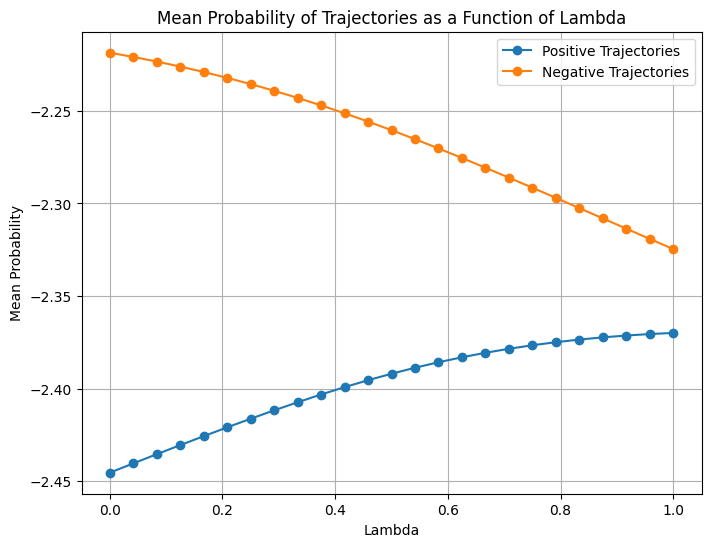

In [28]:
import matplotlib.pyplot as plt

# Compute the mean log probabilities for each lambda value
mean_log_probs_plus = {}
mean_log_probs_minus = {}

for lambda_val in lambdas:
    log_probs_plus = [trajectory['log_probs'][lambda_val] for trajectory in trajectories_plus]
    log_probs_minus = [trajectory['log_probs'][lambda_val] for trajectory in trajectories_minus]
    
    mean_log_probs_plus[lambda_val] = sum(log_probs_plus) / len(log_probs_plus)
    mean_log_probs_minus[lambda_val] = sum(log_probs_minus) / len(log_probs_minus)

# Convert the mean log probabilities to mean probabilities
# mean_probs_plus = {lambda_val: np.exp(log_prob) for lambda_val, log_prob in mean_log_probs_plus.items()}
# mean_probs_minus = {lambda_val: np.exp(log_prob) for lambda_val, log_prob in mean_log_probs_minus.items()}

# keep mean log probabilities as log probabilities
mean_probs_plus = {lambda_val: log_prob for lambda_val, log_prob in mean_log_probs_plus.items()}
mean_probs_minus = {lambda_val: log_prob for lambda_val, log_prob in mean_log_probs_minus.items()}

# Plot the mean probabilities as a function of lambda
plt.figure(figsize=(8, 6))
plt.plot(list(mean_probs_plus.keys()), list(mean_probs_plus.values()), marker='o', label='Positive Trajectories')
plt.plot(list(mean_probs_minus.keys()), list(mean_probs_minus.values()), marker='o', label='Negative Trajectories')
plt.xlabel('Lambda')
plt.ylabel('Mean Log Probability')
plt.title('Mean Log Probability of Trajectories as a Function of Lambda')
plt.legend()
plt.grid(True)
plt.show()

where $\lambda = 1$ corresponds to $\text{past kv}^+$, and conversely $\lambda = 0 \to  \text{past kv}^-$, 

## 5: $\pm \epsilon \mathbf w_v$

Let's use some code from `notebooks/Nudge_Intrinsic_Geometry.ipynb` to see if 
$\pm \epsilon \mathbf w_v$ increases the log-likelihood of the opposite-valence 
trajectory when added to $\text{past kv}^\pm$. 

In [29]:
RESULTS_DIR = '../cache/happy_sad_0330b2024' # this is where weights.npz are kept 
VALUE_REPS_JSON = '../cache/gpt2_happy_sad_0330b2024.json'

# Load weights.npz from RESULTS_DIR
weights = np.load(os.path.join(RESULTS_DIR, 'weights.npz'))
linreg_weights = weights['arr_0']
linreg_bias = weights['arr_1']
print('linreg_weights:', linreg_weights.shape)
print('linreg_bias:', linreg_bias.shape)   

linreg_weights: (1, 9216)
linreg_bias: (1,)


In [30]:
def modify_past_kv(past_kv, epsilon, w_v):
    num_layers = len(past_kv)
    assert len(past_kv[0]) == 2
    batch = past_kv[0][0].shape[0]
    assert batch == 1
    n_heads = past_kv[0][0].shape[1]
    seq_len = past_kv[0][0].shape[2]
    head_dim = past_kv[0][0].shape[3]
    
    layer_dim = batch * n_heads * head_dim
    
    modified_past_kv = []
    for layer in range(num_layers):
        key, value = past_kv[layer]
        weight_vec_l = w_v[:, (layer * layer_dim):((layer + 1) * layer_dim)]
        weight_vec_l = weight_vec_l.reshape((n_heads, head_dim))
        
        modified_value = value.clone()
        modified_value[0, :, -1, :] += epsilon * torch.tensor(weight_vec_l).to(value.device)
        
        modified_past_kv.append((key, modified_value))
    
    return tuple(modified_past_kv)

# Test the modify_past_kv function
epsilon = 0.5
modified_past_kv_plus = modify_past_kv(past_kv_plus, epsilon, linreg_weights)
modified_past_kv_minus = modify_past_kv(past_kv_minus, epsilon, linreg_weights)

# Compare the shapes of the original and modified past_kv
print("Original past_kv_plus shape:", [value.shape for _, value in past_kv_plus])
print("Modified past_kv_plus shape:", [value.shape for _, value in modified_past_kv_plus])
print()
print("Original past_kv_minus shape:", [value.shape for _, value in past_kv_minus])
print("Modified past_kv_minus shape:", [value.shape for _, value in modified_past_kv_minus])

Original past_kv_plus shape: [torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64])]
Modified past_kv_plus shape: [torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64])]

Original past_kv_minus shape: [torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([1, 12, 7, 64]), torch.Size([

In [31]:
def distance_between_past_kv(past_kv1, past_kv2):
    distance = 0
    for layer_past_kv1, layer_past_kv2 in zip(past_kv1, past_kv2):
        _, value1 = layer_past_kv1
        _, value2 = layer_past_kv2
        distance += torch.sum((value1 - value2) ** 2).item()
    return distance

# Test the modify_past_kv function with decreasing epsilon values
epsilon_values = [1.0, 0.5, 0.1, 0.01, 0.001]

for epsilon in epsilon_values:
    modified_past_kv_plus = modify_past_kv(past_kv_plus, epsilon, linreg_weights)
    modified_past_kv_minus = modify_past_kv(past_kv_minus, epsilon, linreg_weights)
    
    distance_plus = distance_between_past_kv(past_kv_plus, modified_past_kv_plus)
    distance_minus = distance_between_past_kv(past_kv_minus, modified_past_kv_minus)
    
    print(f"Epsilon: {epsilon}")
    print(f"Distance between original and modified past_kv_plus: {distance_plus}")
    print(f"Distance between original and modified past_kv_minus: {distance_minus}")
    print()

Epsilon: 1.0
Distance between original and modified past_kv_plus: 325.52894926071167
Distance between original and modified past_kv_minus: 325.528950214386

Epsilon: 0.5
Distance between original and modified past_kv_plus: 81.3822363615036
Distance between original and modified past_kv_minus: 81.38223683834076

Epsilon: 0.1
Distance between original and modified past_kv_plus: 3.2552894400432706
Distance between original and modified past_kv_minus: 3.255289469845593

Epsilon: 0.01
Distance between original and modified past_kv_plus: 0.03255290075321682
Distance between original and modified past_kv_minus: 0.03255288608488627

Epsilon: 0.001
Distance between original and modified past_kv_plus: 0.00032552893878801115
Distance between original and modified past_kv_minus: 0.0003255291206869515



In [32]:
# Define the range of epsilon values to explore
epsilon_range = np.linspace(-1, 1, 21)*1


# Initialize dictionaries to store the mean log probabilities for each epsilon value
mean_log_probs_plus_given_minus = {epsilon: 0 for epsilon in epsilon_range}
mean_log_probs_plus_given_plus = {epsilon: 0 for epsilon in epsilon_range}
mean_log_probs_minus_given_minus = {epsilon: 0 for epsilon in epsilon_range}
mean_log_probs_minus_given_plus = {epsilon: 0 for epsilon in epsilon_range}

# Iterate over the epsilon values
for epsilon in tqdm(epsilon_range, desc="Computing log probs for epsilon"):
    # Modify past_kv_minus and past_kv_plus using epsilon * w_v
    modified_past_kv_minus = modify_past_kv(past_kv_minus, epsilon, linreg_weights)
    modified_past_kv_plus = modify_past_kv(past_kv_plus, epsilon, linreg_weights)
    
    # Compute log probabilities for positive trajectories
    log_probs_plus_given_minus = [get_traj_prob(traj['ids'], modified_past_kv_minus, model) for traj in trajectories_plus]
    log_probs_plus_given_plus = [get_traj_prob(traj['ids'], modified_past_kv_plus, model) for traj in trajectories_plus]
    
    # Compute log probabilities for negative trajectories
    log_probs_minus_given_minus = [get_traj_prob(traj['ids'], modified_past_kv_minus, model) for traj in trajectories_minus]
    log_probs_minus_given_plus = [get_traj_prob(traj['ids'], modified_past_kv_plus, model) for traj in trajectories_minus]
    
    # Calculate mean log probabilities for the current epsilon value
    mean_log_probs_plus_given_minus[epsilon] = np.mean(log_probs_plus_given_minus)
    mean_log_probs_plus_given_plus[epsilon] = np.mean(log_probs_plus_given_plus)
    mean_log_probs_minus_given_minus[epsilon] = np.mean(log_probs_minus_given_minus)
    mean_log_probs_minus_given_plus[epsilon] = np.mean(log_probs_minus_given_plus)

# Convert mean log probabilities to mean probabilities
mean_probs_plus_given_minus = {epsilon: log_prob for epsilon, log_prob in mean_log_probs_plus_given_minus.items()}
mean_probs_plus_given_plus = {epsilon: log_prob for epsilon, log_prob in mean_log_probs_plus_given_plus.items()}
mean_probs_minus_given_minus = {epsilon: log_prob for epsilon, log_prob in mean_log_probs_minus_given_minus.items()}
mean_probs_minus_given_plus = {epsilon: log_prob for epsilon, log_prob in mean_log_probs_minus_given_plus.items()}

# Plot the mean probabilities as a function of epsilon
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(list(mean_probs_plus_given_minus.keys()), list(mean_probs_plus_given_minus.values()), marker='o', label='Positive Trajectories given past_kv_minus')
plt.plot(list(mean_probs_minus_given_minus.keys()), list(mean_probs_minus_given_minus.values()), marker='o', label='Negative Trajectories given past_kv_minus')
plt.xlabel('Epsilon')
plt.ylabel('Mean Log Probability')
plt.title('Mean Log Probability of Trajectories given past_kv_minus')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(mean_probs_plus_given_plus.keys()), list(mean_probs_plus_given_plus.values()), marker='o', label='Positive Trajectories given past_kv_plus')
plt.plot(list(mean_probs_minus_given_plus.keys()), list(mean_probs_minus_given_plus.values()), marker='o', label='Negative Trajectories given past_kv_plus')
plt.xlabel('Epsilon')
plt.ylabel('Mean Log Probability')
plt.title('Mean Log Probability of Trajectories given past_kv_plus')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Computing log probs for epsilon:  10%|▉         | 2/21 [00:12<02:01,  6.39s/it]